In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely

In [2]:
#read data
#all vec lines
fire_vecline=gpd.read_file(r"E:/Mortality/SierraNevada/FrontLine/full_progression_1219_vecline_all.shp")

In [3]:
#get fire line segments
segments=gpd.read_file(r"E:/Mortality/SierraNevada/FrontLine/full_progression_1219_frontline_segment.shp")






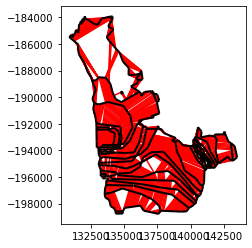

In [20]:
ax=fire_vecline.query("Name=='Lion'").plot(color='red')
segments.query("Name=='Lion'").plot(ax=ax,color='black',linewidth=2)

In [242]:
def pointSegMatch(row,veclines):
    '''
    get a row from the fire segment dataset and find veclines attached to that line
    
    ags:
    row: a row from segment dataset
    veclines: the fire spread vecline dataset
    
    '''
    
    date=row.gridcode
    firename=row.Name
    lines=veclines.loc[(veclines['gridcode']==date)&(veclines['Name']==firename),:].geometry
    inter_vec=lines.intersection(row.geometry).is_empty
    return lines[~inter_vec].unary_union
    
    
    


In [247]:
#for all segments
vec_selected=segments.apply(pointSegMatch,veclines=fire_vecline,axis=1)

In [252]:
segments_vec=segments.copy()
segments_vec['geometry']=gpd.GeoSeries(vec_selected)

In [277]:
segments_vec['vec_len']=segments_vec.length

In [279]:
def aveLength(row,len_name='vec_len'):
    '''
    calculate mean vector line length for each fire day, the gpd of the input row should have length attribute calculated
    
    args:
    len_name: str, name of the length attribute
    '''
    if row.geometry.is_empty:
        return 0
    elif row.geometry.geom_type=='LineString':
        return row[len_name]
    else:
        return row[len_name]/len(row.geometry)
        

In [300]:
def percLength(row,len_name='vec_len',percent=50):
    '''
    calculate percentile of vector line length for each fire day, 
    the gpd of the input row should have length attribute calculated
    
    args:
    len_name: str, name of the length attribute
    percent: numeric, percentile to be calculated; median (50) by default
    '''
    import numpy as np
    
    if row.geometry.is_empty:
        return 0
    elif row.geometry.geom_type=='LineString':
        return row[len_name]
    else:
        lens=[]
        for geom in row.geometry:
            lens.append(geom.length)
        value=np.percentile(lens,percent)
        return value

In [281]:
segments_vec['vec_len_mean']=segments_vec.apply(aveLength,len_name='vec_len',axis=1)

In [283]:
segments_vec.to_file(r"E:\Mortality\SierraNevada\FrontLine\full_progression_1219_fireseg_vecline_090520.shp")

remove fire lines<60m

In [284]:
#remove lines shorter than 60m
segments=segments.loc[segments.length>=60,:]
#search veclines for each line
vec_selected_rm=segments.apply(pointSegMatch,veclines=fire_vecline,axis=1)

In [287]:
segments_vec=segments.copy()
segments_vec['geometry']=gpd.GeoSeries(vec_selected_rm)

In [288]:
segments_vec['vec_len']=segments_vec.length

In [289]:
segments_vec['vec_len_mean']=segments_vec.apply(aveLength,len_name='vec_len',axis=1)

In [301]:
segments_vec['vec_len_median']=segments_vec.apply(percLength,len_name='vec_len',axis=1)

In [303]:
#upper quantile
segments_vec['vec_len_upper']=segments_vec.apply(percLength,len_name='vec_len',percent=75,axis=1)

In [305]:
#upper whisk
segments_vec['vec_len_uw']=segments_vec.apply(percLength,len_name='vec_len',percent=98,axis=1)

In [307]:
#remove empty collections
segments_vec=segments_vec.loc[~segments_vec.is_empty,:]

In [309]:
segments_vec.to_file(r"E:\Mortality\SierraNevada\FrontLine\full_progression_1219_fireseg_vecline_090620.shp")

Create buffer for veclines

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely

vecline=gpd.read_file(r"E:\Mortality\SierraNevada\FrontLine\full_progression_1219_fireseg_vecline_090620.shp")

Combine all buffer together

In [2]:
def create_buffer_clip(row):
    '''
    geopandas only allows scale and resolution parameters when creating buffer;
    use this function with pandas.apply to create one flat buffer for all fire line
    '''
    #create flat buffer (30m, 1 pixels); With a resolution of 1, the buffer is a square patch, the resolution value determine
    #the roundness
    buf=row.geometry.buffer(30,resolution=1,cap_style=2)
    return buf

In [3]:
vec_buffer=vecline.apply(create_buffer_clip,axis=1)

In [9]:
vecline['geometry']=vec_buffer

In [10]:
vecline.to_file(r"E:\Mortality\SierraNevada\FrontLine\full_progression_1219_fireseg_vecbuff_091120.shp")

seperate buffer for seperate vecline

In [16]:
def create_buffer_clip(row):
    '''
    geopandas only allows scale and resolution parameters when creating buffer;
    use this function with pandas.apply to create a flat buffer for each fire line
    if the input is multiline string, create buffer for each linestring
    '''
    #create flat buffer (30m, 1 pixels); With a resolution of 1, the buffer is a square patch, the resolution value determine
    #the roundness
    if row.geometry.geom_type=='LineString':
        buf=row.geometry.buffer(30,resolution=1,cap_style=2)
    else:
        geom_col=[]
        for item in row.geometry:
            geom_col.append(item.buffer(30,resolution=1,cap_style=2))
        buf=shapely.geometry.MultiPolygon(geom_col)
    return buf

In [17]:
vec_buffer=vecline.apply(create_buffer_clip,axis=1)

In [29]:
vecline['geometry']=vec_buffer

In [32]:
vecline.to_file(r"E:\Mortality\SierraNevada\FrontLine\full_progression_1219_fireseg_vecbuff_091020.shp")